In [16]:
import os

if 'google.colab' in str(get_ipython()):
    files = ['util.py',
             'windows.py',
             'models',
             'configs/arima_config_nuovi_positivi',
             'configs/multi_lstm_config_nuovi_positivi',
             'configs/multi_xgb_config_nuovi_positivi',
             'configs/multi_lstm_generator_config_nuovi_positivi',
             'configs/uni_xgb_config_nuovi_positivi',
             'configs/uni_lstm_config_nuovi_positivi',
             'configs/uni_lstm_generator_config_nuovi_positivi',
             'configs/arima_config_deceduti',
             'configs/multi_lstm_config_deceduti',
             'configs/multi_xgb_config_deceduti',
             'configs/multi_lstm_generator_config_deceduti',
             'configs/uni_xgb_config_deceduti',
             'configs/uni_lstm_config_deceduti',
             'configs/uni_lstm_generator_config_deceduti',
             'configs/arima_config_terapia_intensiva',
             'configs/multi_lstm_config_terapia_intensiva',
             'configs/multi_xgb_config_terapia_intensiva',
             'configs/multi_lstm_generator_config_terapia_intensiva',
             'configs/uni_xgb_config_terapia_intensiva',
             'configs/uni_lstm_config_terapia_intensiva',
             'configs/uni_lstm_generator_config_terapia_intensiva']

    for file in files:
        os.system('rm ./' + file)
        os.system(
            'wget -nv https://raw.githubusercontent.com/marco-mazzoli/progetto-tesi/master/' + file)

import pandas as pd
import numpy as np
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima_model import ARIMA
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split

# fix for 'package not found' when installing in Anaconda environment
if 'google.colab' not in str(get_ipython()):
    import pip
    pip.main(['install', 'xgboost'])

from xgboost import XGBRegressor
from util import select_relevant_rows, select_attributes, read_movement_data, download_updated_mobility_data, download_updated_mobility_data, series_to_supervised, split_dates, save_config, load_config, plot_graphs


# Data Acquisition and Data Preparation

In [17]:
use_existing_config = True
column_to_predict = 'nuovi_positivi'
columns = ['nuovi_positivi', 'terapia_intensiva', 'deceduti']
split_percent = 0.80
region_focus = 'Emilia-Romagna'
attribute_focus = 'denominazione_regione'

In [18]:
local_region_path = r'../COVID-19/dati-regioni/dpc-covid19-ita-regioni.csv'
remote_region_path = r'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'

regions_frame = pd.read_csv(remote_region_path)

region_focus_data = select_relevant_rows(
    regions_frame,
    attribute_focus,
    region_focus
)

frame_interesting_columns = select_attributes(region_focus_data, [
    'data',
    'ricoverati_con_sintomi',
    'terapia_intensiva',
    'totale_ospedalizzati',
    'variazione_totale_positivi',
    'nuovi_positivi',
    'deceduti',
    'tamponi',
    'ingressi_terapia_intensiva'
])

frame_interesting_columns = pd.DataFrame(frame_interesting_columns)
frame_interesting_columns['data'] = pd.to_datetime(
    frame_interesting_columns['data'])
frame_interesting_columns['data'] = frame_interesting_columns['data'].dt.strftime(
    r'%Y-%m-%d')
frame_interesting_columns = frame_interesting_columns.fillna(0)

mobility_data_url = r'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'
file_path = r'../Global_Mobility_Report.csv'
mobility_data_zip_url = r'https://www.gstatic.com/covid19/mobility/Region_Mobility_Report_CSVs.zip'
zip_path = r'../Region_Mobility_Report_CSVs.zip'
region_mobility_path = r'../Region_Mobility_Report_CSVs'

download_updated_mobility_data(
    mobility_data_url,
    file_path,
    region_mobility_path,
    mobility_data_zip_url,
    zip_path
)

mobility_df = read_movement_data(
    region_mobility_path,
    'IT_Region_Mobility_Report',
    region='Emilia-Romagna'
)

mobility_df = mobility_df[['date',
                           'retail_and_recreation_percent_change_from_baseline',
                           'grocery_and_pharmacy_percent_change_from_baseline',
                           'parks_percent_change_from_baseline',
                           'transit_stations_percent_change_from_baseline',
                           'workplaces_percent_change_from_baseline',
                           'residential_percent_change_from_baseline']].fillna(0)

frame_interesting_columns.rename(columns={'data': 'date'}, inplace=True)
frame_interesting_columns.set_index('date', inplace=True)
mobility_df.set_index('date', inplace=True)

# revert cumulative data
frame_interesting_columns['deceduti'] = frame_interesting_columns['deceduti'].diff(
)
frame_interesting_columns['tamponi'] = frame_interesting_columns['tamponi'].diff(
)
frame_interesting_columns.dropna(inplace=True)

merged = pd.merge(
    frame_interesting_columns,
    mobility_df,
    on='date'
)

merged = merged.fillna(0)
merged.set_index(pd.DatetimeIndex(merged.index), inplace=True)

merged.tail()


Data already up to date...


,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,variazione_totale_positivi,nuovi_positivi,deceduti,tamponi,ingressi_terapia_intensiva,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,,,,,,,
2021-11-17,459,41,500,358,756,2.0,40433.0,3.0,-6.0,21.0,8.0,-19.0,-7.0,3.0
2021-11-18,456,45,501,576,929,9.0,35121.0,10.0,-5.0,17.0,15.0,-17.0,-6.0,3.0
2021-11-19,468,49,517,658,1014,7.0,33128.0,6.0,-5.0,22.0,16.0,-15.0,-7.0,3.0
2021-11-20,489,51,540,719,1055,2.0,32999.0,4.0,-6.0,19.0,19.0,-13.0,-6.0,2.0
2021-11-21,522,52,574,707,998,7.0,26351.0,3.0,-12.0,9.0,14.0,-15.0,-8.0,3.0


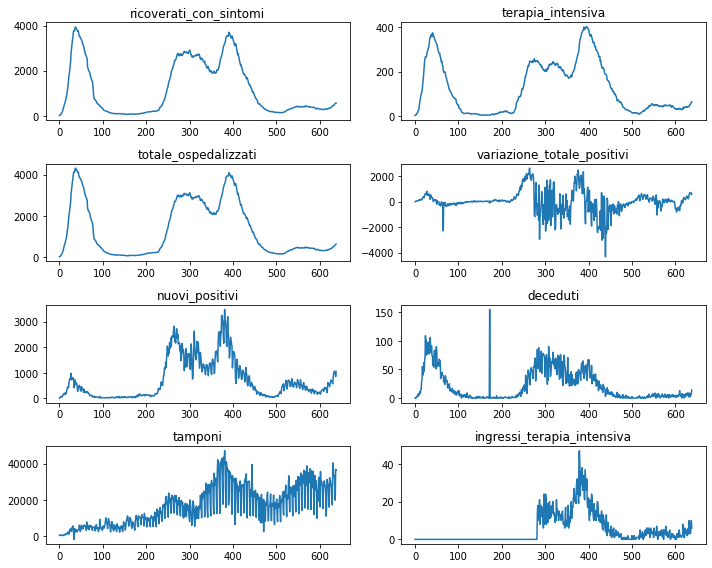

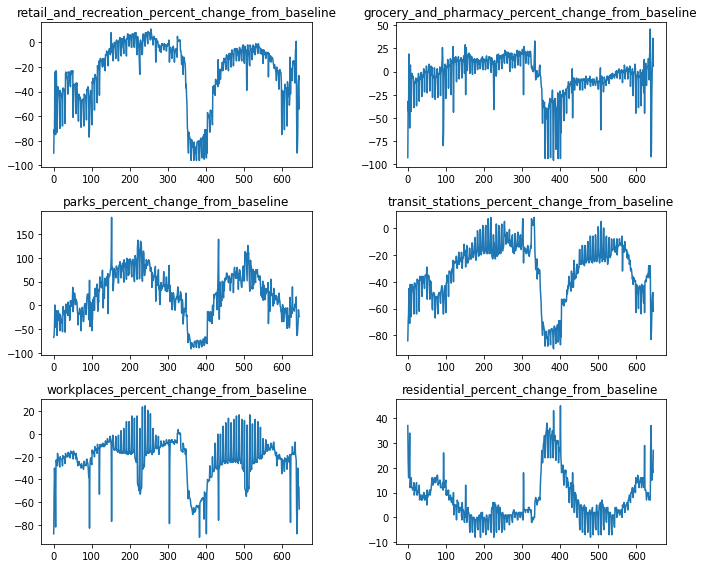

In [19]:
fig, axes = pyplot.subplots(nrows=4, ncols=2, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
    data = np.array(
        frame_interesting_columns[frame_interesting_columns.columns[i]])
    ax.plot(pd.DataFrame(data))
    ax.set_title(frame_interesting_columns.columns[i])
    ax.plot()

pyplot.tight_layout()

fig, axes = pyplot.subplots(nrows=3, ncols=2, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
    data = np.array(mobility_df[mobility_df.columns[i]])
    ax.plot(pd.DataFrame(data))
    ax.set_title(mobility_df.columns[i])
    ax.plot()

pyplot.tight_layout()


# Univariate XGBoost

In [20]:
def define_xgb_configs():
    max_depth = [3, 6, 10, 20]
    learning_rate = [0.01, 0.05, 0.1, 0.5]
    n_estimators = [50, 100, 500, 1000, 5000]
    colsample_bytree = [0.3, 0.7]
    look_back = [1, 2, 4, 7]
    n_future = [1],
    objectives = ['reg:squarederror']

    configs = []
    keys = ['max_depth', 'learning_rate', 'n_estimators', 'colsample_bytree',
            'look_back', 'n_future', 'objective']

    for i in max_depth:
        for j in learning_rate:
            for k in n_estimators:
                for l in colsample_bytree:
                    for m in look_back:
                        for n in n_future:
                            for o in objectives:
                                config = dict(
                                    zip(keys, (i, j, k, l, m, n, o)))
                            configs.append(config)

    return configs


def execute_xgb(
        dataframe, column_to_predict, config, split_percent=0.80, multi=False):
    if multi:
        frame = pd.DataFrame(dataframe).copy()
    else:
        frame = pd.DataFrame(dataframe[column_to_predict]).copy()

    index_to_predict = frame.columns.get_loc(column_to_predict)

    scalers = {}

    for column in frame:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scalers[column] = scaler
        frame[column] = scaler.fit_transform(
            frame[column].values.reshape(-1, 1))

    values = frame.values

    look_back = config['look_back']
    split = int(split_percent*len(values))

    train = values[:split]
    test = values[split:]

    train_reframed = series_to_supervised(
        pd.DataFrame(train), window=look_back,
        index_to_predict=index_to_predict).values
    test_reframed = series_to_supervised(
        pd.DataFrame(test), window=look_back,
        index_to_predict=index_to_predict).values

    train_X, train_y = train_reframed[:, :-1], train_reframed[:, -1]
    test_X, test_y = test_reframed[:, :-1], test_reframed[:, -1]

    model = define_xgb(config)
    model.fit(train_X, train_y)

    prediction = model.predict(test_X)

    prediction = scalers[column_to_predict].inverse_transform(
        prediction.reshape(-1, 1)).reshape(-1)
    test_y = scalers[column_to_predict].inverse_transform(
        test_y.reshape(-1, 1)).reshape(-1)

    error = mean_absolute_error(test_y, prediction)

    return prediction, test_y, error


def grid_search_xgb(
        dataframe, column_to_predict, split_percent=0.80, multi=False):
    configs = define_xgb_configs()
    results = []

    for config in configs:
        _, _, error = execute_xgb(
            dataframe, column_to_predict, config, split_percent=split_percent,
            multi=multi)

        results.append((error, config))

    return results


def define_xgb(config):
    model = XGBRegressor(**config)
    return model


In [21]:
config_path = 'uni_xgb_config' + '_' + column_to_predict

if use_existing_config and os.path.isfile(config_path):
    config = load_config(config_path)
    prediction, test, error = execute_xgb(
        frame_interesting_columns, split_percent=split_percent, config=config,
        column_to_predict=column_to_predict, multi=False)
    look_back = config['look_back']
else:
    results = grid_search_xgb(
        frame_interesting_columns, split_percent=split_percent,
        column_to_predict=column_to_predict, multi=False)

    results.sort(key=lambda tup: tup[0])

    config = results[0][-1]
    look_back = config['look_back']

    save_config(config_path, config)

    prediction, test, error = execute_xgb(
        frame_interesting_columns, split_percent=split_percent, config=config,
        column_to_predict=column_to_predict, multi=False)

print('Best Config')
print(config)
print('MAE: %.3f' % error)

plot_graphs(
    frame_interesting_columns, prediction, split_percent, column_to_predict,
    look_back)


Best Config
{'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 50, 'colsample_bytree': 0.7, 'look_back': 7, 'n_future': [1], 'objective': 'reg:squarederror'}
MAE: 74.851


# Multivariate XGBoost

In [22]:
config_path = 'multi_xgb_config' + '_' + column_to_predict

if use_existing_config and os.path.isfile(config_path):
    config = load_config(config_path)
    prediction, test, error = execute_xgb(
        frame_interesting_columns, split_percent=split_percent, config=config,
        column_to_predict=column_to_predict, multi=True)
    look_back = config['look_back']
else:
    results = grid_search_xgb(
        frame_interesting_columns, split_percent=split_percent,
        column_to_predict=column_to_predict, multi=True)

    results.sort(key=lambda tup: tup[0])

    config = results[0][-1]
    look_back = config['look_back']

    save_config(config_path, config)

    prediction, test, error = execute_xgb(
        frame_interesting_columns, split_percent=split_percent, config=config,
        column_to_predict=column_to_predict, multi=False)

print('Best Config')
print(config)
print('MAE: %.3f' % error)

plot_graphs(
    frame_interesting_columns, prediction, split_percent, column_to_predict,
    look_back)


Best Config
{'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100, 'colsample_bytree': 0.7, 'look_back': 4, 'n_future': [1], 'objective': 'reg:squarederror'}
MAE: 58.341


#ARIMA

In [23]:
def execute_arima(dataframe, order, column_to_predict, split_percent):
    frame = pd.DataFrame(dataframe[column_to_predict])

    split = int(split_percent*len(frame))

    train = frame[:split].values
    test = frame[split:].values

    history = [x for x in train]
    predictions = list()

    for timestep in range(len(test)):
        model = ARIMA(history, order=order)
        model_fitted = model.fit()
        prediction = model_fitted.forecast()[0]
        predictions.append(prediction)
        history.append(test[timestep])

    predictions = np.array(predictions).reshape(-1)
    test = np.array(test).reshape(-1)

    error = mean_absolute_error(test, predictions)
    return predictions, test, error


def define_arima_configs():
    p_values = [1, 8, 10]
    d_values = range(1, 2)
    q_values = range(1, 2)
    return p_values, d_values, q_values


def evaluate_models(dataframe, column_to_predict, split_percent):
    p_values, d_values, q_values = define_arima_configs()
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                _, _, error = execute_arima(
                    dataframe, order, column_to_predict, split_percent)
                if error < best_score:
                    best_score, best_cfg = error, order
    print('Best Model:%s MAE=%.3f' % (best_cfg, best_score))
    return best_cfg


In [24]:
config_path = 'arima_config' + '_' + column_to_predict

if use_existing_config:
    config = load_config(config_path)
    predictions, test, error = execute_arima(
        frame_interesting_columns, config, column_to_predict, split_percent)
else:
    config = evaluate_models(
        frame_interesting_columns, column_to_predict, split_percent)

    save_config(config_path, config)

    predictions, test, error = execute_arima(
        frame_interesting_columns, config, column_to_predict, split_percent)

print('Best Config')
print(config)
print('MAE: %.3f' % error)

plot_graphs(
    frame_interesting_columns, predictions, split_percent, column_to_predict,
    look_back=0)


Best Config
(10, 1, 1)
MAE: 48.040


In [25]:
def define_compile_lstm(config, input_shape):
    model = Sequential()
    model.add(LSTM(config['input'], activation=config['activation'],
                   input_shape=input_shape, return_sequences=True))
    model.add(LSTM(config['hidden'], activation=config['activation'],
                   return_sequences=False))
    model.add(Dropout(config['dropout']))
    model.add(Dense(config['out']))
    model.compile(optimizer=config['optimizer'], loss=config['loss'])
    return model


def define_lstm_configs():
    input = [32, 64, 128]
    hidden = [32, 64, 128]
    activation = ['relu']
    dropout = [0.1, 0.2]
    out = [1]
    optimizer = ['adam']
    loss = ['mae']
    look_back = [1, 2, 4, 7]
    n_future = [1]

    configs = []
    keys = ['input', 'hidden', 'activation', 'dropout', 'out',
            'optimizer', 'loss', 'look_back', 'n_future']

    for i in input:
        for j in hidden:
            for k in activation:
                for l in dropout:
                    for m in out:
                        for n in optimizer:
                            for o in loss:
                                for p in look_back:
                                    for q in n_future:
                                        config = dict(
                                            zip(keys, (i, j, k, l, m, n, o, p, q)))
                                        configs.append(config)

    return configs


def execute_lstm(
        dataframe, column_to_predict, config, split_percent=0.80, multi=False):
    if multi:
        frame = pd.DataFrame(dataframe).copy()
    else:
        frame = pd.DataFrame(dataframe[column_to_predict]).copy()

    index_to_predict = frame.columns.get_loc(column_to_predict)

    scalers = {}

    for column in frame:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scalers[column] = scaler
        frame[column] = scaler.fit_transform(
            frame[column].values.reshape(-1, 1))

    look_back = config['look_back']
    split = int(split_percent*len(frame))

    train = frame[:split].values
    test = frame[split:].values

    train_X, test_X = [], []
    train_y, test_y = [], []

    n_future = config['n_future']

    if multi:
        for i in range(look_back, len(train) - n_future + 1):
            train_X.append(train[i - look_back:i, 0:train.shape[1]])
            train_y.append(train[i + n_future - 1:i +
                           n_future, index_to_predict])

        for i in range(look_back, len(test) - n_future + 1):
            test_X.append(test[i - look_back:i, 0:test.shape[1]])
            test_y.append(test[i + n_future - 1:i +
                          n_future, index_to_predict])

        train_X, train_y = np.array(train_X), np.array(train_y)
        test_X, test_y = np.array(test_X), np.array(test_y)
    else:
        train_reframed = series_to_supervised(
            pd.DataFrame(train), look_back).values
        test_reframed = series_to_supervised(
            pd.DataFrame(test), look_back).values

        train_X, train_y = train_reframed[:, :-1], train_reframed[:, -1]
        test_X, test_y = test_reframed[:, :-1], test_reframed[:, -1]

        train_X = train_X.reshape(
            (train_X.shape[0], train_X.shape[1], len(frame.columns)))
        test_X = test_X.reshape(
            (test_X.shape[0], test_X.shape[1], len(frame.columns)))
        test_y = test_y.reshape(-1, 1)

    input_shape = (look_back, len(frame.columns))

    model = define_compile_lstm(config, input_shape=input_shape)

    history = model.fit(
        train_X, train_y, epochs=50, validation_data=(test_X, test_y),
        verbose=0, shuffle=False)

    prediction = model.predict(test_X)

    prediction = scalers[column_to_predict].inverse_transform(
        prediction).reshape(-1)
    test_y = scalers[column_to_predict].inverse_transform(test_y).reshape(-1)

    error = mean_absolute_error(test_y, prediction)

    return prediction, test_y, error, input_shape, history


def grid_search_lstm(
        dataframe, column_to_predict, split_percent=0.80, multi=False):
    configs = define_lstm_configs()
    results = []
    for config in configs:
        _, _, error, input_shape, _ = execute_lstm(
            dataframe, column_to_predict, config, split_percent=split_percent,
            multi=multi)

        results.append((error, input_shape, config))

    return results


def plot_loss(history):
    pyplot.plot(history.history['loss'], label='Training loss')
    pyplot.plot(history.history['val_loss'], label='Validation loss')
    pyplot.legend()
    pyplot.show()


In [26]:
def execute_lstm_generator(
        dataframe, column_to_predict, config, split_percent=0.80, multi=False):
    if multi:
        frame = pd.DataFrame(dataframe).copy()
    else:
        frame = pd.DataFrame(dataframe[column_to_predict]).copy()

    index_to_predict = frame.columns.get_loc(column_to_predict)

    scalers = {}

    for column in frame:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scalers[column] = scaler
        frame[column] = scaler.fit_transform(
            frame[column].values.reshape(-1, 1))

    look_back = config['look_back']

    train_X, test_X = [], []
    train_y, test_y = [], []

    values = frame.values

    X = values[:][:]
    y = values[:, index_to_predict][:]

    split = int(split_percent*len(frame))

    train = frame[:split].values
    test = frame[split:].values

    train_X, test_X, train_y, test_y = train_test_split(
        X, y, test_size=0.20, shuffle=False)

    input_shape = (look_back, len(frame.columns))

    if multi:
        train_generator = TimeseriesGenerator(
            train_X, train_y, sampling_rate=1, length=look_back)
        test_generator = TimeseriesGenerator(
            test_X, test_y, sampling_rate=1, length=look_back)
    else:
        train_generator = TimeseriesGenerator(
            train, train, length=look_back)
        test_generator = TimeseriesGenerator(
            test, test, length=look_back)

    model = define_compile_lstm(config, input_shape=input_shape)

    history = model.fit(
        train_generator, epochs=50, validation_data=test_generator,
        verbose=0, shuffle=False)

    prediction = model.predict(test_generator)

    test_y = test_y.reshape(-1, 1)
    test_y = test_y[look_back:]

    prediction = scalers[column_to_predict].inverse_transform(
        prediction).reshape(-1)
    test_y = scalers[column_to_predict].inverse_transform(test_y).reshape(-1)

    error = mean_absolute_error(prediction, test_y)

    return prediction, test_y, error, input_shape, history


def grid_search_lstm_generator(
        dataframe, column_to_predict, split_percent=0.80, multi=False):
    configs = define_lstm_configs()
    results = []
    for config in configs:
        _, _, error, input_shape, _ = execute_lstm_generator(
            dataframe, column_to_predict, config, split_percent=split_percent,
            multi=multi)

        results.append((error, input_shape, config))

    return results


# LSTM Univariate


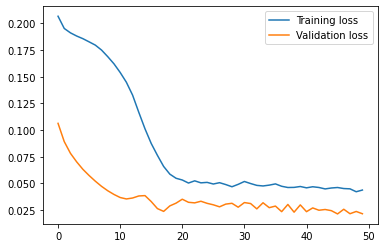

Best Config
{'input': 64, 'hidden': 32, 'activation': 'relu', 'dropout': 0.2, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 1, 'n_future': 1}
MAE: 74.779


In [27]:
config_path = 'uni_lstm_config' + '_' + column_to_predict

if use_existing_config and os.path.isfile(config_path):
    config = load_config(config_path)
    prediction, _, error, _, history = execute_lstm(
        frame_interesting_columns, column_to_predict=column_to_predict,
        config=config, split_percent=split_percent, multi=False)
    look_back = config['look_back']
else:
    results = grid_search_lstm(
        frame_interesting_columns, column_to_predict, split_percent=split_percent,
        multi=False)

    results.sort()
    config = results[0][-1]
    look_back = config['look_back']

    save_config(config_path, config)

    prediction, _, error, _, history = execute_lstm(
        frame_interesting_columns, column_to_predict=column_to_predict,
        config=config, split_percent=split_percent, multi=False)

plot_loss(history)

print('Best Config')
print(config)
print('MAE: %.3f' % error)

plot_graphs(
    frame_interesting_columns, prediction, split_percent, column_to_predict,
    look_back)


#Univariate LSTM with TimeseriesGenerator

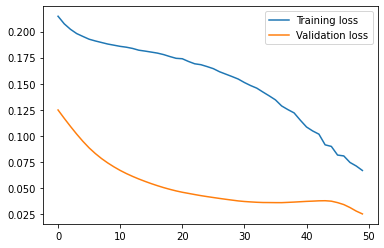

Best Config
{'input': 64, 'hidden': 64, 'activation': 'relu', 'dropout': 0.2, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 1, 'n_future': 1}
MAE: 86.832


In [28]:
config_path = 'uni_lstm_generator_config' + '_' + column_to_predict

if use_existing_config and os.path.isfile(config_path):
    config = load_config(config_path)
    prediction, _, error, _, history = execute_lstm_generator(
        frame_interesting_columns, column_to_predict=column_to_predict,
        config=config, split_percent=split_percent, multi=False)
    look_back = config['look_back']
else:
    results = grid_search_lstm_generator(
        frame_interesting_columns, column_to_predict, split_percent=split_percent,
        multi=False)

    results.sort()
    config = results[0][-1]
    look_back = config['look_back']

    save_config(config_path, config)

    prediction, _, error, _, history = execute_lstm_generator(
        frame_interesting_columns, column_to_predict=column_to_predict,
        config=config, split_percent=split_percent, multi=False)

plot_loss(history)

print('Best Config')
print(config)
print('MAE: %.3f' % error)

plot_graphs(
    frame_interesting_columns, prediction, split_percent, column_to_predict,
    look_back)


# Multivariate LSTM

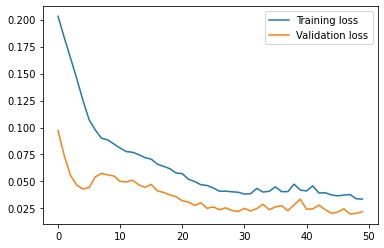

Best Config
{'input': 128, 'hidden': 64, 'activation': 'relu', 'dropout': 0.1, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 1, 'n_future': 1}
MAE: 76.343


In [29]:
config_path = 'multi_lstm_config' + '_' + column_to_predict

if use_existing_config and os.path.isfile(config_path):
    config = load_config(config_path)
    prediction, _, error, _, history = execute_lstm(
        frame_interesting_columns, column_to_predict=column_to_predict,
        config=config, split_percent=split_percent, multi=True)
    look_back = config['look_back']
else:
    results = grid_search_lstm(
        frame_interesting_columns, column_to_predict, split_percent=split_percent,
        multi=True)

    results.sort()
    config = results[0][-1]
    look_back = config['look_back']

    save_config(config_path, config)

    prediction, _, error, _, history = execute_lstm(
        frame_interesting_columns, column_to_predict=column_to_predict,
        config=config, split_percent=split_percent, multi=True)

plot_loss(history)

print('Best Config')
print(config)
print('MAE: %.3f' % error)

plot_graphs(
    frame_interesting_columns, prediction, split_percent, column_to_predict,
    look_back)


# Multivariate LSTM with TimeseriesGenerator

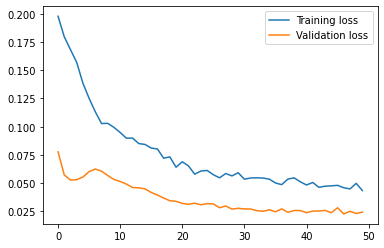

Best Config
{'input': 64, 'hidden': 32, 'activation': 'relu', 'dropout': 0.2, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 7, 'n_future': 1}
MAE: 84.045


In [30]:
config_path = 'multi_lstm_generator_config' + '_' + column_to_predict

if use_existing_config and os.path.isfile(config_path):
    config = load_config(config_path)
    prediction, _, error, _, history = execute_lstm_generator(
        frame_interesting_columns, column_to_predict=column_to_predict,
        config=config, split_percent=split_percent, multi=True)
    look_back = config['look_back']
else:
    results = grid_search_lstm_generator(
        frame_interesting_columns, column_to_predict, split_percent=split_percent,
        multi=True)

    results.sort()
    config = results[0][-1]
    look_back = config['look_back']

    save_config(config_path, config)

    prediction, _, error, _, history = execute_lstm_generator(
        frame_interesting_columns, column_to_predict=column_to_predict,
        config=config, split_percent=split_percent, multi=True)

plot_loss(history)

print('Best Config')
print(config)
print('MAE: %.3f' % error)

plot_graphs(
    frame_interesting_columns, prediction, split_percent, column_to_predict,
    look_back)
